In [1]:
!wget www.ivan-sipiran.com/downloads/yolo.zip
!unzip yolo.zip

--2022-10-12 14:50:50--  http://www.ivan-sipiran.com/downloads/yolo.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233686170 (223M) [application/zip]
Saving to: ‘yolo.zip’

yolo.zip            100%[===================>] 222.86M  9.12MB/s    in 64s     

2022-10-12 14:51:55 (3.47 MB/s) - ‘yolo.zip’ saved [233686170/233686170]

Archive:  yolo.zip
   creating: config/
  inflating: config/coco.data        
  inflating: config/coco.names       
  inflating: config/download_weights.sh  
  inflating: config/yolov3-tiny.cfg  
  inflating: config/yolov3.cfg       
  inflating: config/yolov3.weights   
   creating: images/
  inflating: images/blueangels-det.jpg  
  inflating: images/blueangels.jpg   
  inflating: images/Intersection-Counts.jpg  
  inflating: images/olympic-trials.jpg  
   creating: utils/
  inflating: utils/dat

In [2]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [3]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [4]:
classes

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [5]:
#Funcion para detectar objetos en una imagen
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

Inference Time: 0:00:00.061801


<Figure size 432x288 with 0 Axes>

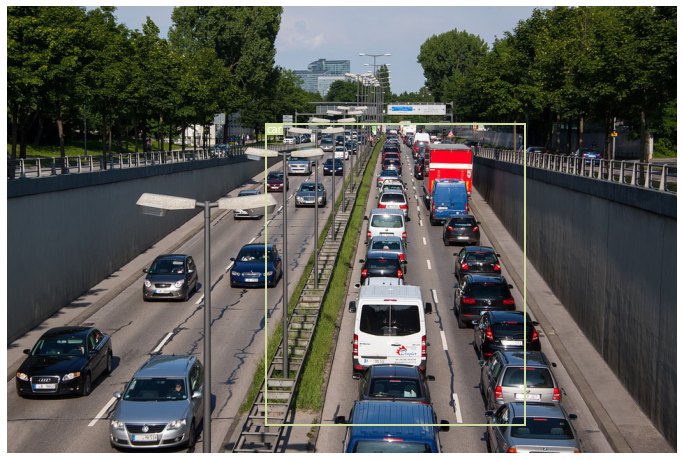

In [10]:
# load image and get detections
conf_thres=0.05
img_path = "traffic.jpg"

prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes(
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections.cpu():
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

In [7]:
!wget https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg -O people.jpg

--2022-10-12 15:01:50--  https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg
Resolving www.wsha.org (www.wsha.org)... 141.193.213.11, 141.193.213.10
Connecting to www.wsha.org (www.wsha.org)|141.193.213.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1923610 (1.8M) [image/jpeg]
Saving to: ‘people.jpg’

people.jpg          100%[===================>]   1.83M  2.24MB/s    in 0.8s    

2022-10-12 15:01:52 (2.24 MB/s) - ‘people.jpg’ saved [1923610/1923610]



In [9]:
!wget https://cdn.pixabay.com/photo/2013/07/05/01/08/traffic-143391_960_720.jpg -O traffic.jpg

--2022-10-12 15:02:23--  https://cdn.pixabay.com/photo/2013/07/05/01/08/traffic-143391_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 172.64.150.12, 104.18.37.244, 2606:4700:4400::ac40:960c, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|172.64.150.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 259865 (254K) [binary/octet-stream]
Saving to: ‘traffic.jpg’

traffic.jpg         100%[===================>] 253.77K  --.-KB/s    in 0.04s   

2022-10-12 15:02:23 (6.70 MB/s) - ‘traffic.jpg’ saved [259865/259865]

